## Predictive Comparison

#### Imports

In [1]:
import random 

import numpy as np
import pandas as pd
from tqdm import tqdm

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

/Users/bea/opt/anaconda3/envs/mlbd/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


#### Importing data

In [2]:
def build_vocab(model):
    emb_vectors = {}
    for n in model.wv.index_to_key:
        emb_vectors[n] = model.wv[n]
    return emb_vectors

def load_model(filename):
    model = Word2Vec.load(filename)
    emb_vectors = build_vocab(model)
    return emb_vectors, model

In [3]:
user_history_df = pd.read_pickle('data/user_history_df')
merged_user_history_df = pd.read_pickle('data/artist_merged_user_history_df')
double_merged_user_history_df = pd.read_pickle('data/artist_tracks_merged_user_history_df')
renamed_double_merged_user_history_df = pd.read_pickle('data/renamed_artist_track_double_merged_user_history_df')

#### Defining Eval functions

In [4]:
def get_document(df):
    # order listening history and discard negligible number of tracks that have no name
    df = df.sort_values("timestamp")
    df = df[~df.track_name.isna()]
    
    # create a unique song id for each unique track and artist name combination
    df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
                        + df.track_name.cat.codes
    assert len(df.query("song_id < 0")) == 0 #Check underflow
    
    # create and retrun the "document" (a list of "sentences")
    return df.groupby("user_id").agg(sentences=("song_id", list))

In [5]:
def get_predict_performance(df, model, predict_top_n=10, nb_tests_per_run=10000, n_runs=10):

    sentences = get_document(df)
    top_performance = []
    top_n_performance = []

    for _ in range(n_runs):

        unsuitable_users = 0
        nb_correct_guess = 0
        nb_top_n_correct_guess = 0

        for _ in tqdm(range(nb_tests_per_run)):

            # get a random user's sentences
            user_id = random.choice(user_history_df.user_id.unique())
            user_sentence = sentences.loc[user_id].values[0]

            # extract a chunk from any part of their listening history
            if len(user_sentence) < 12:
                unsuitable_users = unsuitable_users + 1
                continue
            range_start = np.random.randint(len(user_sentence) - 11)

            predict_sentence_chunk = user_sentence[ range_start  : range_start+5 ] + \
                                     user_sentence[range_start+6 : range_start+11]
            prediction = model.predict_output_word(predict_sentence_chunk, topn=predict_top_n)

            if prediction != None and any(user_sentence[5] == p[0] for p in prediction):
                nb_top_n_correct_guess = nb_top_n_correct_guess + 1    
                if user_sentence[5] == prediction[0][0]:
                    nb_correct_guess = nb_correct_guess + 1

        top_perf = nb_correct_guess/(nb_tests_per_run-unsuitable_users)
        top_n_perf = nb_top_n_correct_guess/(nb_tests_per_run-unsuitable_users)

        print(f"Correct guesses: {top_perf}")
        print(f"Correct top-10 guesses: {top_n_perf}")
        
        top_performance.append(top_perf)
        top_n_performance.append(top_n_perf)
        
    
    return top_performance, top_n_performance

### CBOW models

#### Loading models in

In [4]:
cbow_baseline_embs, cbow_baseline_model = load_model("word2vecs/cbow/baseline_model.model")
cbow_merged_artist_embs, cbow_merged_artist_model = load_model("word2vecs/cbow/merged_artist_model.model")
cbow_fully_merged_embs, cbow_fully_merged_model = load_model("word2vecs/cbow/fully_merged_model.model")
cbow_renamed_merged_embs, cbow_renamed_merged_model = load_model("word2vecs/cbow/renamed_merged_model.model")

#### Running Eval

In [42]:
cbow_baseline_top_performance, cbow_baseline_top_n_performance = \
                get_predict_performance(user_history_df, cbow_baseline_model)

  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0020149103364900263
Correct top-10 guesses: 0.006346967559943582


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0026180646460577986
Correct top-10 guesses: 0.005840298056590474


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0016133911465160836
Correct top-10 guesses: 0.005041847332862761


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.002518130539887188
Correct top-10 guesses: 0.006345688960515713


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0014097271171080454
Correct top-10 guesses: 0.005236129292115597


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.001714746822675005
Correct top-10 guesses: 0.006354649989913254


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0025173698519786528
Correct top-10 guesses: 0.006343772026986205


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0016117658910043315
Correct top-10 guesses: 0.006447063564017326


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.001713882447827402
Correct top-10 guesses: 0.005746547030950701


100%|██████████| 10000/10000 [34:05<00:00,  4.89it/s]


Correct guesses: 0.0013077155215773062
Correct top-10 guesses: 0.0058344230962679815


In [43]:
cbow_renamed_merged_top_performance, cbow_renamed_merged_top_n_performance = \
        get_predict_performance(renamed_double_merged_user_history_df, cbow_renamed_merged_model)

  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0007045088566827697
Correct top-10 guesses: 0.006340579710144928


  0%|          | 1/10000 [00:00<34:09,  4.88it/s]

Correct guesses: 0.0008059641345960105
Correct top-10 guesses: 0.006246222043119081


  0%|          | 1/10000 [00:00<33:28,  4.98it/s]

Correct guesses: 0.0012079726192872962
Correct top-10 guesses: 0.006643849406080129


  0%|          | 1/10000 [00:00<34:31,  4.83it/s]

Correct guesses: 0.0009057059474690551
Correct top-10 guesses: 0.0076481835564053535


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0016101439066116534
Correct top-10 guesses: 0.008855791486364093


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0007057874571486187
Correct top-10 guesses: 0.0071587013510788465


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0012095554883580285
Correct top-10 guesses: 0.0060477774417901425


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0008051529790660225
Correct top-10 guesses: 0.006743156199677938


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0013086370042279041
Correct top-10 guesses: 0.006341856251258305


100%|██████████| 10000/10000 [33:32<00:00,  4.97it/s]

Correct guesses: 0.002118857834729089
Correct top-10 guesses: 0.0072646554333568765


In [52]:
cbow_fully_merged_top_performance, cbow_fully_merged_top_n_performance = \
        get_predict_performance(double_merged_user_history_df, cbow_fully_merged_model)

  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.001007759750075582
Correct top-10 guesses: 0.0054419026504081425


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0014090177133655394
Correct top-10 guesses: 0.005938003220611917


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0029172115481339907
Correct top-10 guesses: 0.008047480132783422


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0019155156769835669
Correct top-10 guesses: 0.006452263332997278


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0015099657741091202
Correct top-10 guesses: 0.0067445137910207365


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0013100876750982565
Correct top-10 guesses: 0.005845006550438375


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0013126009693053312
Correct top-10 guesses: 0.0046445880452342485


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0020122748767481637
Correct top-10 guesses: 0.00724418955629339


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0019122383252818036
Correct top-10 guesses: 0.005032206119162641


100%|██████████| 10000/10000 [33:47<00:00,  4.93it/s]


Correct guesses: 0.001812141347025068
Correct top-10 guesses: 0.006443169233866908


---

#### Plotting intermediate results

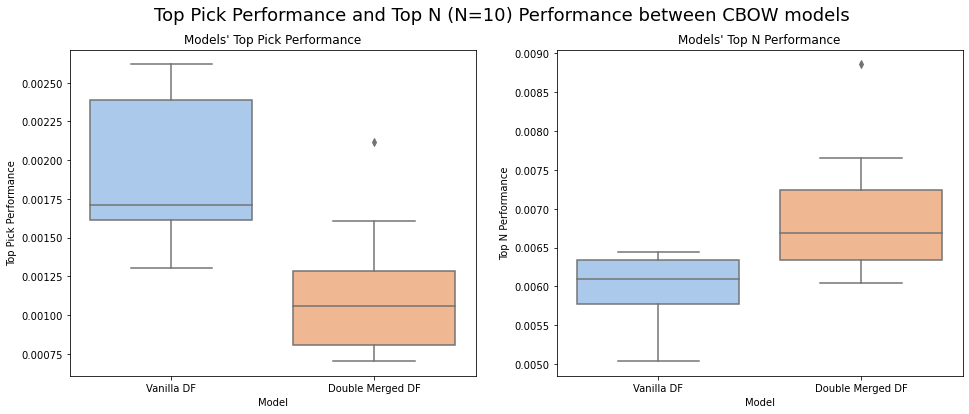

In [45]:
# "merge" all metrics into a single table so that confidence intervals can later be plotted
models_metrics = []
for model, top_perfs, top_n_perfs in [('Vanilla DF', cbow_baseline_top_performance, cbow_baseline_top_n_performance),
                                      ('Double Merged DF', cbow_renamed_merged_top_performance, cbow_renamed_merged_top_n_performance)]:
    for i in range(len(top_perfs)):
        models_metrics.append([model, top_perfs[i], top_n_perfs[i]])
        
models_metrics = pd.DataFrame(models_metrics, columns=['Model', 'Top Pick Performance', 'Top N Performance'])
# models_metrics.to_pickle('data/backup/cbow_metrics')

# plot both metrics
f, ax = plt.subplots(1, 2, figsize=(16,6))
for i, metric in enumerate(['Top Pick Performance', 'Top N Performance']):
    sns.boxplot(data=models_metrics, x='Model', y=metric, palette='pastel', ax=ax[i])
    ax[i].set_title(f'Models\' {metric}')
    ax[i].set_ylabel(metric)

plt.suptitle('Top Pick Performance and Top N (N=10) Performance between CBOW models', fontsize = 18)
plt.show()

---

#### Final results

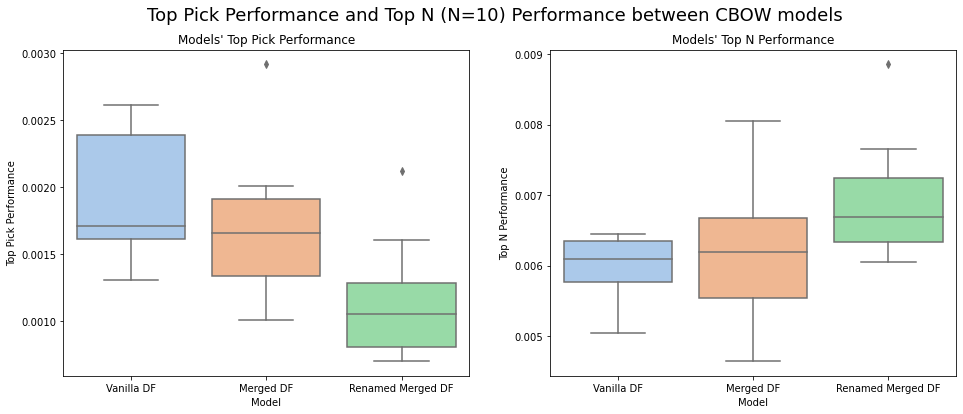

In [56]:
# "merge" all metrics into a single table so that confidence intervals can later be plotted
models_metrics = []
for model, top_perfs, top_n_perfs in [('Vanilla DF', cbow_baseline_top_performance, cbow_baseline_top_n_performance),
                                      ('Merged DF', cbow_fully_merged_top_performance, cbow_fully_merged_top_n_performance),
                                      ('Renamed Merged DF', cbow_renamed_merged_top_performance, cbow_renamed_merged_top_n_performance)]:
    for i in range(len(top_perfs)):
        models_metrics.append([model, top_perfs[i], top_n_perfs[i]])
        
models_metrics = pd.DataFrame(models_metrics, columns=['Model', 'Top Pick Performance', 'Top N Performance'])
# models_metrics.to_pickle('data/backup/cbow_metrics')

# plot both metrics
f, ax = plt.subplots(1, 2, figsize=(16,6))
for i, metric in enumerate(['Top Pick Performance', 'Top N Performance']):
    sns.boxplot(data=models_metrics, x='Model', y=metric, palette='pastel', ax=ax[i])
    ax[i].set_title(f'Models\' {metric}')
    ax[i].set_ylabel(metric)

plt.suptitle('Top Pick Performance and Top N (N=10) Performance between CBOW models', fontsize = 18)
plt.show()

### Skipgram models

#### Loading models in

In [8]:
sg_baseline_embs, sg_baseline_model = load_model("word2vecs/sg/baseline_model.model")
sg_merged_artist_embs, sg_merged_artist_model = load_model("word2vecs/sg/merged_artist_model.model")
sg_fully_merged_embs, sg_fully_merged_model = load_model("word2vecs/sg/fully_merged_model.model")
sg_renamed_merged_embs, sg_renamed_merged_model = load_model("word2vecs/sg/renamed_merged_model.model")

#### Running Eval

In [47]:
sg_baseline_top_performance, sg_baseline_top_n_performance = \
        get_predict_performance(user_history_df, sg_baseline_model)

  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0017125012591921024
Correct top-10 guesses: 0.013297068600785736


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0015104219111871915
Correct top-10 guesses: 0.011781290907260095


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0023162134944612286
Correct top-10 guesses: 0.011681772406847936


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.001910507792860734
Correct top-10 guesses: 0.011764705882352941


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0027149321266968325
Correct top-10 guesses: 0.013775766716943187


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.002313650538175234
Correct top-10 guesses: 0.011367065687556584


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.001914936504736948
Correct top-10 guesses: 0.010280185446482563


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0016116035455278
Correct top-10 guesses: 0.010273972602739725


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0024225295245785807
Correct top-10 guesses: 0.012112647622892905


100%|██████████| 10000/10000 [34:48<00:00,  4.79it/s]


Correct guesses: 0.0022152854697412142
Correct top-10 guesses: 0.011881985701339241


In [48]:
sg_renamed_merged_top_performance, sg_renamed_merged_top_n_performance = \
        get_predict_performance(renamed_double_merged_user_history_df, sg_renamed_merged_model)

  0%|          | 1/10000 [00:00<33:31,  4.97it/s]

Correct guesses: 0.001509509912448425
Correct top-10 guesses: 0.013082419241219684


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0011079774375503627
Correct top-10 guesses: 0.012087026591458501


  0%|          | 1/10000 [00:00<33:30,  4.97it/s]

Correct guesses: 0.0012096774193548388
Correct top-10 guesses: 0.011794354838709678


  0%|          | 1/10000 [00:00<33:10,  5.02it/s]

Correct guesses: 0.0018143332325370426
Correct top-10 guesses: 0.013103517790545308


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0018134193028410237
Correct top-10 guesses: 0.012190207535764658


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.001108089050065478
Correct top-10 guesses: 0.01098015513246701


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.001007252215954875
Correct top-10 guesses: 0.011784850926672039


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0013081102837593076
Correct top-10 guesses: 0.013081102837593077


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0014088759182851968
Correct top-10 guesses: 0.01157290932877126


100%|██████████| 10000/10000 [33:02<00:00,  5.04it/s]


Correct guesses: 0.001712156309799577
Correct top-10 guesses: 0.011179373552220767


In [54]:
sg_fully_merged_top_performance, sg_fully_merged_top_n_performance = \
        get_predict_performance(double_merged_user_history_df, sg_fully_merged_model)

  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.002112888620585572
Correct top-10 guesses: 0.009658919408391186


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.002015316404675534
Correct top-10 guesses: 0.010882708585247884


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0020130850528434826
Correct top-10 guesses: 0.01097131353799698


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0030205396697543293
Correct top-10 guesses: 0.010169150221506242


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.002519907267412559
Correct top-10 guesses: 0.012599536337062796


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0021124635348556482
Correct top-10 guesses: 0.011467659189216377


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.002614641995172969
Correct top-10 guesses: 0.011363636363636364


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.0021143777688280305
Correct top-10 guesses: 0.011578735400724929


  0%|          | 0/10000 [00:00<?, ?it/s]

Correct guesses: 0.002723970944309927
Correct top-10 guesses: 0.011702986279257466


100%|██████████| 10000/10000 [36:23<00:00,  4.58it/s]

Correct guesses: 0.0020189783969311527
Correct top-10 guesses: 0.011003432263274783


#### Plotting intermediate results

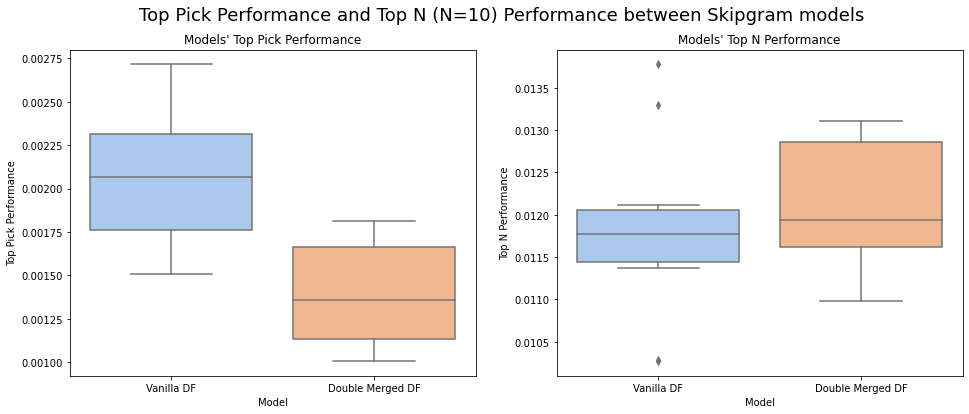

In [49]:
# "merge" all metrics into a single table so that confidence intervals can later be plotted
models_metrics = []
for model, top_perfs, top_n_perfs in [('Vanilla DF', sg_baseline_top_performance, sg_baseline_top_n_performance),
                                      ('Double Merged DF', sg_renamed_merged_top_performance, sg_renamed_merged_top_n_performance)]:
    for i in range(len(top_perfs)):
        models_metrics.append([model, top_perfs[i], top_n_perfs[i]])
        
models_metrics = pd.DataFrame(models_metrics, columns=['Model', 'Top Pick Performance', 'Top N Performance'])
models_metrics.to_pickle('data/backup/sg_metrics')

# plot both metrics
f, ax = plt.subplots(1, 2, figsize=(16,6))
for i, metric in enumerate(['Top Pick Performance', 'Top N Performance']):
    sns.boxplot(data=models_metrics, x='Model', y=metric, palette='pastel', ax=ax[i])
    ax[i].set_title(f'Models\' {metric}')
    ax[i].set_ylabel(metric)

plt.suptitle('Top Pick Performance and Top N (N=10) Performance between Skipgram models', fontsize = 18)
plt.show()

---

#### Final results

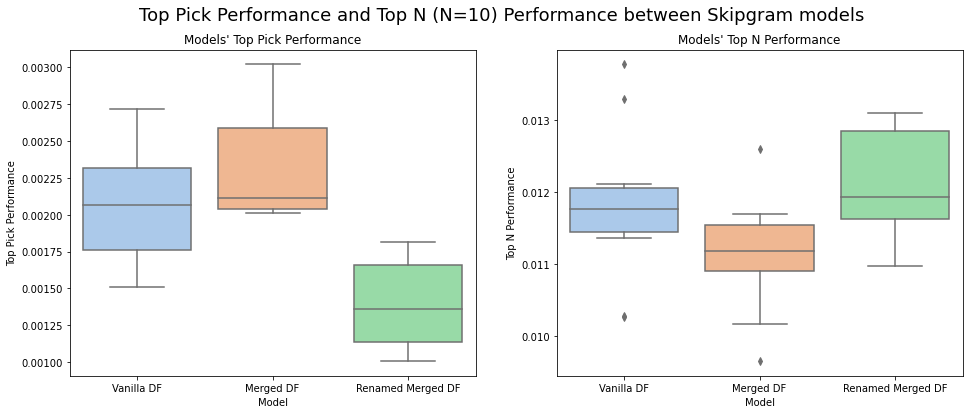

In [55]:
# "merge" all metrics into a single table so that confidence intervals can later be plotted
models_metrics = []
for model, top_perfs, top_n_perfs in [('Vanilla DF', sg_baseline_top_performance, sg_baseline_top_n_performance),
                                      ('Merged DF', sg_fully_merged_top_performance, sg_fully_merged_top_n_performance),
                                      ('Renamed Merged DF', sg_renamed_merged_top_performance, sg_renamed_merged_top_n_performance)]:
    for i in range(len(top_perfs)):
        models_metrics.append([model, top_perfs[i], top_n_perfs[i]])
        
models_metrics = pd.DataFrame(models_metrics, columns=['Model', 'Top Pick Performance', 'Top N Performance'])
# models_metrics.to_pickle('data/backup/sg_metrics')

# plot both metrics
f, ax = plt.subplots(1, 2, figsize=(16,6))
for i, metric in enumerate(['Top Pick Performance', 'Top N Performance']):
    sns.boxplot(data=models_metrics, x='Model', y=metric, palette='pastel', ax=ax[i])
    ax[i].set_title(f'Models\' {metric}')
    ax[i].set_ylabel(metric)

plt.suptitle('Top Pick Performance and Top N (N=10) Performance between Skipgram models', fontsize = 18)
plt.show()

---

## Visualizations

#### Setup

In [6]:
import plotly.express as px
from sklearn.decomposition import PCA

In [8]:
sg_renamed_merged_embs, sg_renamed_merged_model = load_model("word2vecs/sg/renamed_merged_model.model")

In [ ]:
def add_song_ids(df):
    # order listening history and discard negligible number of tracks that have no name
    df = df.sort_values("timestamp")
    df = df[~df.track_name.isna()]
    
    # create a unique song id for each unique track and artist name combination
    df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
                        + df.track_name.cat.codes
    assert len(df.query("song_id < 0")) == 0 #Check underflow
    
    # create and retrun the "document" (a list of "sentences")
    return df

#### By number of song listens

In [24]:
# apply PCA
sg_df = pd.DataFrame(sg_renamed_merged_embs).T
pca = PCA(n_components=2)
components = pd.DataFrame(pca.fit_transform(sg_df))
components.columns = [str(i) for i in components.columns]

count_df = pd.DataFrame(add_song_ids(renamed_double_merged_user_history_df).groupby(['song_id'])['song_id'].count())
count_df.columns = ['song_count']
sg_df = (sg_df
         .reset_index()
         .merge(add_song_ids(renamed_double_merged_user_history_df)[['artist_name', 'track_name', 'song_id']
                             ].drop_duplicates(['song_id']), how='left', right_on='song_id', left_on='index')
         .drop(['index'], axis=1)
         .merge(count_df, left_on='song_id', right_index=True, how='left')
         .sort_values(by='song_count', ascending=False))

In [31]:
points_to_display = 1000   # 1000 songs takes approx 2m30s

# plot the vectors
fig = px.scatter(components[:points_to_display], x='0', y='1', color=sg_df.artist_name[:points_to_display], 
                 title='Embeddings 2D visualization',
                 hover_data = {'0': False, 
                               '1': False,
                               'Track': sg_df.track_name[:points_to_display],
                               'Count': sg_df.song_count[:points_to_display]}
                )

# make the figure more readable
fig.update_layout(showlegend=False)
for data in fig.data:
    template = (data.hovertemplate.replace("color=", "<b>Artist:</b> ")
                                  .replace("Track=", "<b>Track:</b> ")
                                  .replace("Count=", "<b>Total listens in dataset:</b> "))
    data.hovertemplate = template

fig.show()

#### By top artists

In [52]:
artists_to_display = 20
top_artists = (renamed_double_merged_user_history_df
               .groupby('artist_name').count()['track_name']
               .sort_values(ascending=False)).index[:artists_to_display]

# apply PCA
sg_df = pd.DataFrame(sg_renamed_merged_embs).T
pca = PCA(n_components=2)
components = pd.DataFrame(pca.fit_transform(sg_df))
components.columns = [str(i) for i in components.columns]

count_df = pd.DataFrame(add_song_ids(renamed_double_merged_user_history_df).groupby(['song_id'])['song_id'].count())
count_df.columns = ['song_count']
sg_df = (sg_df
         .reset_index()
         .merge(add_song_ids(renamed_double_merged_user_history_df)[['artist_name', 'track_name', 'song_id']
                             ].drop_duplicates(['song_id']), how='left', right_on='song_id', left_on='index')
         .drop(['index'], axis=1)
         .merge(count_df, left_on='song_id', right_index=True, how='left')
         .sort_values(by='song_count', ascending=False))

In [65]:
top_artists_index = sg_df['artist_name'].isin(top_artists)
components = components[top_artists_index.values]
sg_df = sg_df[top_artists_index]

# plot the vectors
fig = px.scatter(components, x='0', y='1', color=sg_df.artist_name, 
                 title='Embeddings 2D visualization',
                 hover_data = {'0': False, 
                               '1': False,
                               'Track': sg_df.track_name,
                               'Count': sg_df.song_count}
                )

# make the figure more readable
for data in fig.data:
    template = (data.hovertemplate.replace("color=", "<b>Artist:</b> ")
                                  .replace("Track=", "<b>Track:</b> ")
                                  .replace("Count=", "<b>Total listens in dataset:</b> "))
    data.hovertemplate = template

fig.show()